In [2]:
#importing necessary packages

from tensorflow.keras.utils import array_to_img, img_to_array, load_img

from sklearn.utils import class_weight , compute_class_weight


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import tensorflow as tf
from keras import datasets, layers, models
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, Activation
from keras.models import Sequential
from keras.optimizers import Adam , SGD, RMSprop
from keras.utils import array_to_img, img_to_array, load_img
from keras.regularizers import l1 , l2 
from keras.wrappers import scikit_learn
from keras.callbacks import EarlyStopping
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' # This prevents kernel shut down due to xgboost conflict
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # This line prevents tf's comments about the optimizing your machine

# Directory path
train_dir = 'chest_xray/train/'
test_dir = 'chest_xray/test/'
val_dir = 'chest_xray/val/'

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)



# Get all the data in the directory chest_xray/train (5216 images) and reshape them
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size = (200, 200),
        batch_size=5216, class_mode='binary')

# Get all the data in the directory chest_xray/test (624 images) , and reshape them
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size = (200, 200),
        batch_size=624, class_mode='binary')


# Get all the data in the directory chest_xray/val (16 images), and reshape them
val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size = (200, 200),
        batch_size=16, class_mode='binary')


In [ ]:
# may try data augmentation if needed 

# Data Augmentation will be performed only on the training set
# All image sets will be rescaled by 1./255
#train_datagen = ImageDataGenerator(rescale=1./255, 
#                                   rotation_range=20, 
#                                   width_shift_range=0.2, 
#                                   height_shift_range=0.2, 
#                                   shear_range=0.2, 
#                                   zoom_range=0.2, 
#                                   horizontal_flip=True)
#val_datagen = ImageDataGenerator(rescale=1./255)
#test_datagen = ImageDataGenerator(rescale=1./255)

In [2]:
# Directory path
train_dir = 'chest_xray/train/'
test_dir = 'chest_xray/test/'
val_dir = 'chest_xray/val/'

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)



# Get all the data in the directory chest_xray/train (5216 images) and reshape them
train_generator = train_datagen.flow_from_directory(
        train_dir,
        batch_size=5216, class_mode='binary')

# Get all the data in the directory chest_xray/test (624 images) , and reshape them
test_generator = test_datagen.flow_from_directory(
        test_dir,
        batch_size=624, class_mode='binary')


# Get all the data in the directory chest_xray/val (16 images), and reshape them
val_generator = val_datagen.flow_from_directory(
        val_dir,
        batch_size=16, class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [3]:
# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [4]:
# Previewing shape of each dataset

print("Image Dataset Shape")
print(train_images.shape)
print(test_images.shape)
print(val_images.shape)

print("Label Dataset Shape")
print(train_labels.shape)
print(test_labels.shape)
print(val_labels.shape)



Image Dataset Shape
(5216, 256, 256, 3)
(624, 256, 256, 3)
(16, 256, 256, 3)
Label Dataset Shape
(5216,)
(624,)
(16,)


In [5]:
example_img = train_images[10]

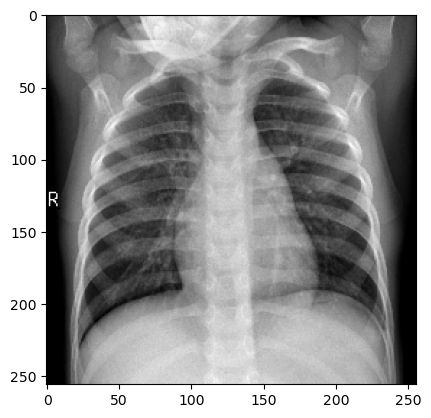

In [6]:
plt.imshow(example_img)

In [7]:
# Reshaping image datasets
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(5216, 196608)
(624, 196608)
(16, 196608)


In [8]:
train_img[:10]

array([[0.14117648, 0.14117648, 0.14117648, ..., 0.20784315, 0.20784315,
        0.20784315],
       [0.65882355, 0.65882355, 0.65882355, ..., 0.04313726, 0.04313726,
        0.04313726],
       [0.07450981, 0.07450981, 0.07450981, ..., 0.1254902 , 0.1254902 ,
        0.1254902 ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01176471, 0.01176471, 0.01176471, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [8]:
# Reshaping labels
train_y = np.reshape(train_labels, (5216,1))
test_y = np.reshape(test_labels, (624,1))
val_y = np.reshape(val_labels, (16,1))

print(train_y.shape)
print(test_y.shape)
print(val_y.shape)

(5216, 1)
(624, 1)
(16, 1)


In [10]:
# Viewing first 10 labels
train_y[:10]

array([[1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.]], dtype=float32)

In [11]:
# Viewing class indices
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

## Baseline Model 

In [12]:
# Baseline model

model_1 = Sequential()
model_1.add(Dense(12, activation='relu', input_shape=(196608,)))
model_1.add(Dense(8, activation='relu'))
model_1.add(Dense(1, activation='sigmoid'))

# Compiling model with following parameters
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Inspecting model summary

model_1.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                2359308   
                                                                 
 dense_1 (Dense)             (None, 8)                 104       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,359,421
Trainable params: 2,359,421
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fitting the model to the training data
results_1 = model_1.fit(train_img, train_y, 
                        epochs=10, 
                        batch_size=32, 
                        validation_data=(val_img, val_y))

Epoch 1/10
163/163 [==============================] - 30s 169ms/step - loss: 0.6825 - accuracy: 0.7398 - val_loss: 0.7026 - val_accuracy: 0.5000
Epoch 2/10
163/163 [==============================] - 22s 136ms/step - loss: 0.6093 - accuracy: 0.7429 - val_loss: 0.7431 - val_accuracy: 0.5000
Epoch 3/10
163/163 [==============================] - 14s 86ms/step - loss: 0.5788 - accuracy: 0.7429 - val_loss: 0.7895 - val_accuracy: 0.5000
Epoch 4/10
163/163 [==============================] - 17s 102ms/step - loss: 0.5714 - accuracy: 0.7429 - val_loss: 0.8126 - val_accuracy: 0.5000
Epoch 5/10
163/163 [==============================] - 13s 79ms/step - loss: 0.5702 - accuracy: 0.7429 - val_loss: 0.8231 - val_accuracy: 0.5000
Epoch 6/10
163/163 [==============================] - 15s 94ms/step - loss: 0.5701 - accuracy: 0.7429 - val_loss: 0.8256 - val_accuracy: 0.5000
Epoch 7/10
163/163 [==============================] - 11s 66ms/step - loss: 0.5700 - accuracy: 0.7429 - val_loss: 0.8270 - val_accura

In [14]:
# Training Results 
results_train = model_1.evaluate(train_img, train_y)

# Test Results 

results_test = model_1.evaluate(test_img, test_y)

20/20 [==============================] - 3s 108ms/step - loss: 0.6930 - accuracy: 0.6250


In [15]:
print('Train Results:', results_train)
print('Test Results:', results_test)

Train Results: [0.5700258016586304, 0.7429064512252808]
Test Results: [0.6930213570594788, 0.625]


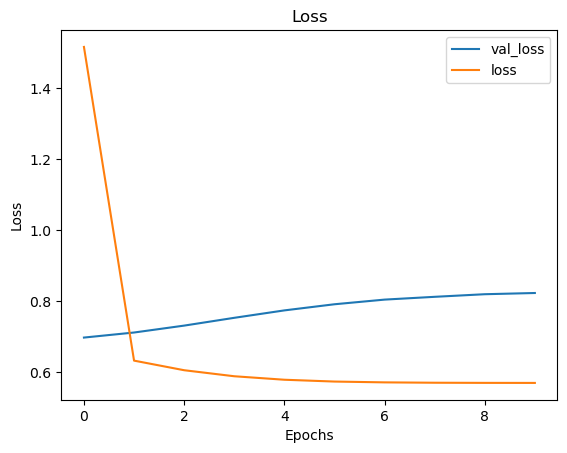

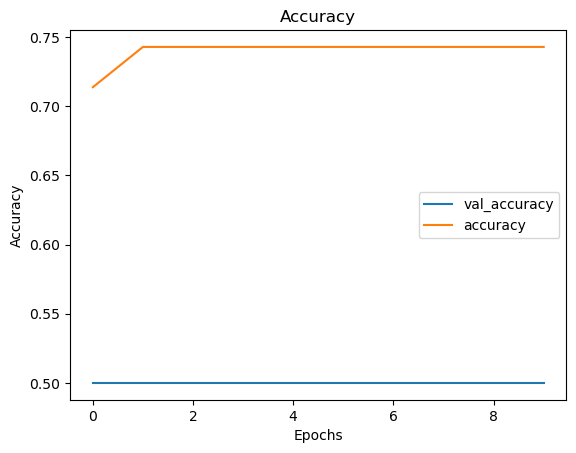

In [16]:
# Creating function to plot loss and accuracy curves

def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

# Viewing results 
visualize_training_results(results_1)

## Model 2

In [17]:
# Model 2 changing activation function in first 2 layers

model_2 = Sequential()
model_2.add(Dense(12, activation='tanh', input_shape=(196608,)))
model_2.add(Dense(8, activation='tanh'))
model_2.add(Dense(1, activation='sigmoid'))

# Compiling model with following parameters
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Inspecting model summary

model_2.summary()

# Fitting the model to the training data
results_2 = model_2.fit(train_img, train_y, 
                        epochs=10, 
                        batch_size=32, 
                        validation_data=(val_img, val_y))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 12)                2359308   
                                                                 
 dense_4 (Dense)             (None, 8)                 104       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,359,421
Trainable params: 2,359,421
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
163/163 [==============================] - 22s 123ms/step - loss: 0.5749 - accuracy: 0.7414 - val_loss: 0.8099 - val_accuracy: 0.5000
Epoch 2/10
163/163 [==============================] - 19s 114ms/step - loss: 0.5707 - accuracy: 0.7429 - val_loss: 0.8365 - val_accuracy: 0.5000
Epoch 3/10
163/163

In [18]:
# Training Results 
results2_train = model_2.evaluate(train_img, train_y)

# Test Results 

results2_test = model_2.evaluate(test_img, test_y)

20/20 [==============================] - 2s 64ms/step - loss: 0.6953 - accuracy: 0.6250


In [19]:
print('Train Results:', results2_train)
print('Test Results:', results2_test)

Train Results: [0.5699954032897949, 0.7429064512252808]
Test Results: [0.6953195333480835, 0.625]


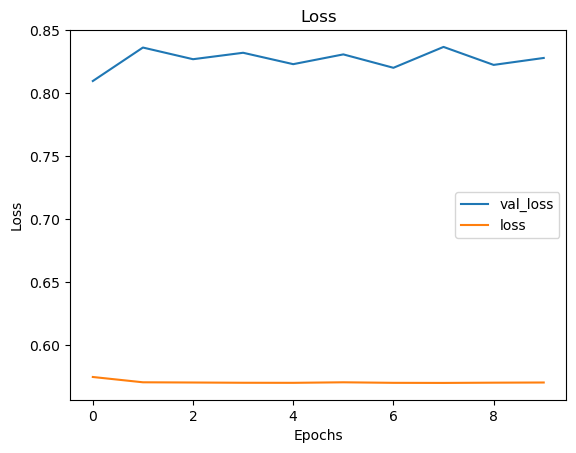

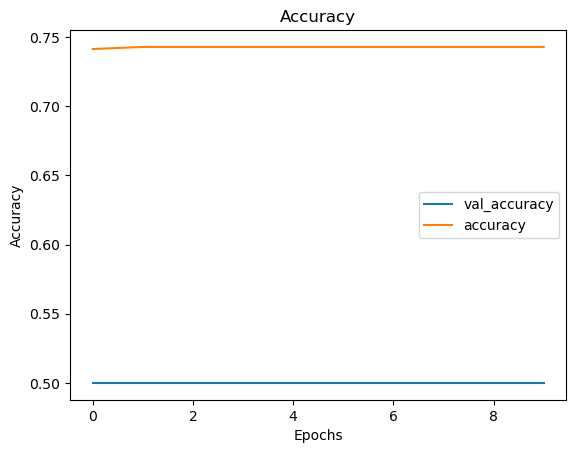

In [20]:
# Creating function to plot loss and accuracy curves

def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

# Viewing results 
visualize_training_results(results_2)

## Model 3

In [21]:
# Model 3 
# Adding more neurons per layer and one extra layer 

model_3 = Sequential()
model_3.add(Dense(64, activation='tanh', input_shape=(196608,)))
model_3.add(Dense(32, activation='tanh'))
model_3.add(Dense(16, activation='tanh'))
model_3.add(Dense(1, activation='sigmoid'))

# Compiling model with following parameters
model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Inspecting model summary

model_3.summary()

# Fitting the model to the training data
results_3 = model_3.fit(train_img, train_y, 
                        epochs=10, 
                        batch_size=32, 
                        validation_data=(val_img, val_y))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                12582976  
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 16)                528       
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 12,585,601
Trainable params: 12,585,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
163/163 [==============================] - 32s 187ms/step - loss: 0.5761 - accuracy: 0.7391 - val_loss: 0.8030 - val_accuracy: 0.5000
Epoch 2/10
163/163 [=========

In [22]:
# Training Results 
results3_train = model_3.evaluate(train_img, train_y)

# Test Results 

results3_test = model_3.evaluate(test_img, test_y)

20/20 [==============================] - 3s 103ms/step - loss: 0.6952 - accuracy: 0.6250


In [23]:
print('Train Results:', results3_train)
print('Test Results:', results3_test)

Train Results: [0.569995105266571, 0.7429064512252808]
Test Results: [0.695216178894043, 0.625]


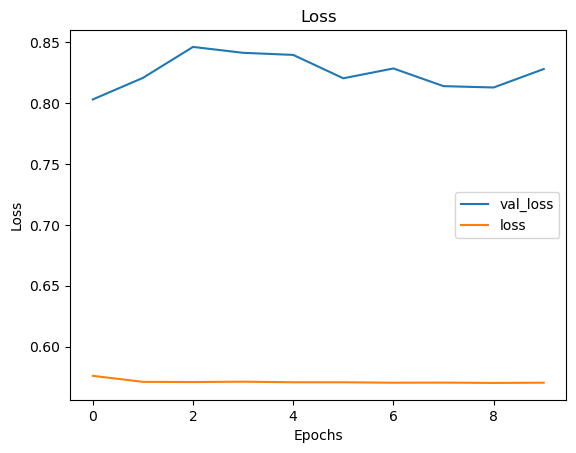

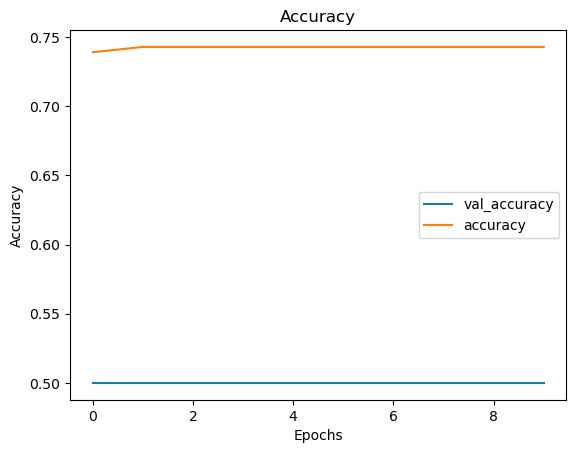

In [24]:
# Viewing results 
visualize_training_results(results_3)

## Model 4

In [25]:
# Model 4
# adjusting activation function from previous model 3

model_4 = Sequential()
model_4.add(Dense(64, activation='relu', input_shape=(196608,)))
model_4.add(Dense(32, activation='relu'))
model_4.add(Dense(16, activation='relu'))
model_4.add(Dense(1, activation='sigmoid'))

# Compiling model with following parameters
model_4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Inspecting model summary

model_4.summary()

# Fitting the model to the training data
results_4 = model_4.fit(train_img, train_y, 
                        epochs=10, 
                        batch_size=32, 
                        validation_data=(val_img, val_y))



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 64)                12582976  
                                                                 
 dense_11 (Dense)            (None, 32)                2080      
                                                                 
 dense_12 (Dense)            (None, 16)                528       
                                                                 
 dense_13 (Dense)            (None, 1)                 17        
                                                                 
Total params: 12,585,601
Trainable params: 12,585,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
163/163 [==============================] - 44s 257ms/step - loss: 0.8471 - accuracy: 0.8286 - val_loss: 0.2849 - val_accuracy: 0.8750
Epoch 2/10
163/163 [=========

In [26]:
# Training Results 
results4_train = model_4.evaluate(train_img, train_y)

# Test Results 
results4_test = model_4.evaluate(test_img, test_y)

print('Train Results:', results4_train)
print('Test Results:', results4_test)


20/20 [==============================] - 2s 75ms/step - loss: 0.9515 - accuracy: 0.7660
Train Results: [0.08690128475427628, 0.9695168733596802]
Test Results: [0.9514895677566528, 0.7660256624221802]


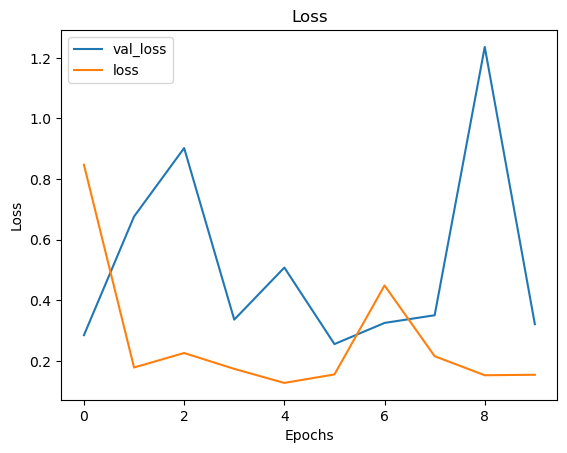

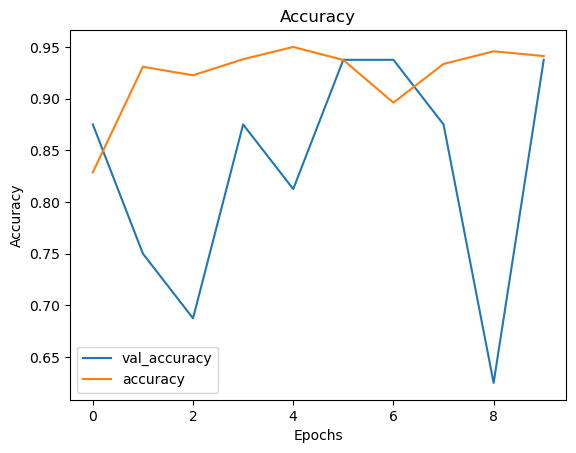

In [27]:
# Viewing results 
visualize_training_results(results_4)

## Model 5

In [28]:
# Model 5 increased epochs from 10 to 20 


model_5 = Sequential()
model_5.add(Dense(64, activation='relu', input_shape=(196608,)))
model_5.add(Dense(32, activation='relu'))
model_5.add(Dense(16, activation='relu'))
model_5.add(Dense(1, activation='sigmoid'))

# Compiling model with following parameters
model_5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Inspecting model summary

model_5.summary()

# Fitting the model to the training data
results_5 = model_5.fit(train_img, train_y, 
                        epochs=20, 
                        batch_size=32, 
                        validation_data=(val_img, val_y))



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 64)                12582976  
                                                                 
 dense_15 (Dense)            (None, 32)                2080      
                                                                 
 dense_16 (Dense)            (None, 16)                528       
                                                                 
 dense_17 (Dense)            (None, 1)                 17        
                                                                 
Total params: 12,585,601
Trainable params: 12,585,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
163/163 [==============================] - 32s 187ms/step - loss: 1.0587 - accuracy: 0.8273 - val_loss: 0.9226 - val_accuracy: 0.6875
Epoch 2/20
163/163 [=========

In [29]:
# Training Results 
results5_train = model_5.evaluate(train_img, train_y)

# Test Results 
results5_test = model_5.evaluate(test_img, test_y)

print('Train Results:', results5_train)
print('Test Results:', results5_test)


20/20 [==============================] - 2s 73ms/step - loss: 0.5025 - accuracy: 0.8141
Train Results: [0.1903623342514038, 0.9321318864822388]
Test Results: [0.5024653673171997, 0.8141025900840759]


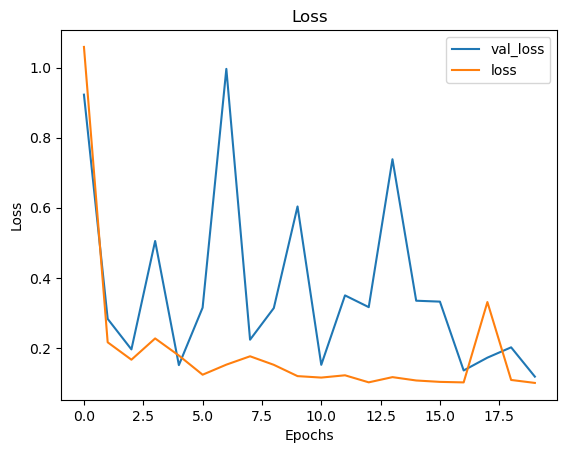

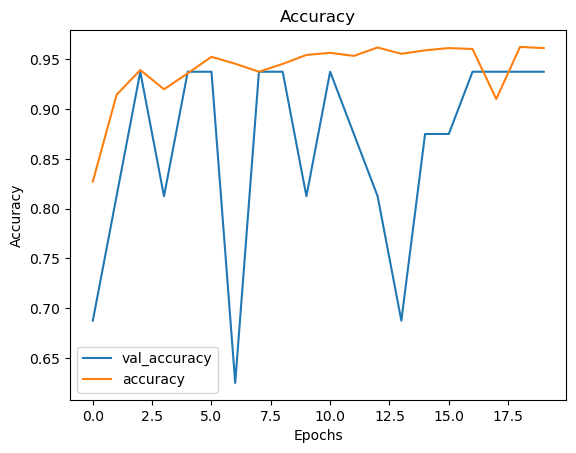

In [30]:
# Viewing results 
visualize_training_results(results_5)

With the increase to 20 epochs the training accuracy increased while test accuracy also increased greatly from the previous model. Looking at the top visual, we can see that loss seems to be improving as Epochs are increase. 

I plan to increase the Epochs to 50 to see how this influences the metrics. 

## Model 6

In [31]:
# Model 6 increased epochs from 20 to 30


model_6 = Sequential()
model_6.add(Dense(64, activation='relu', input_shape=(196608,)))
model_6.add(Dense(32, activation='relu'))
model_6.add(Dense(16, activation='relu'))
model_6.add(Dense(1, activation='sigmoid'))

# Compiling model with following parameters
model_6.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Inspecting model summary

model_6.summary()

# Fitting the model to the training data
results_6 = model_6.fit(train_img, train_y, 
                        epochs=30, 
                        batch_size=32, 
                        validation_data=(val_img, val_y))



Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 64)                12582976  
                                                                 
 dense_19 (Dense)            (None, 32)                2080      
                                                                 
 dense_20 (Dense)            (None, 16)                528       
                                                                 
 dense_21 (Dense)            (None, 1)                 17        
                                                                 
Total params: 12,585,601
Trainable params: 12,585,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
163/163 [==============================] - 44s 254ms/step - loss: 1.7641 - accuracy: 0.8232 - val_loss: 2.6814 - val_accuracy: 0.6250
Epoch 2/30
163/163 [=========

In [32]:
# Training Results 
results6_train = model_6.evaluate(train_img, train_y)

# Test Results 
results6_test = model_6.evaluate(test_img, test_y)

print('Train Results:', results6_train)
print('Test Results:', results6_test)


20/20 [==============================] - 3s 108ms/step - loss: 0.5682 - accuracy: 0.8125
Train Results: [0.09268513321876526, 0.9647239446640015]
Test Results: [0.5682278275489807, 0.8125]


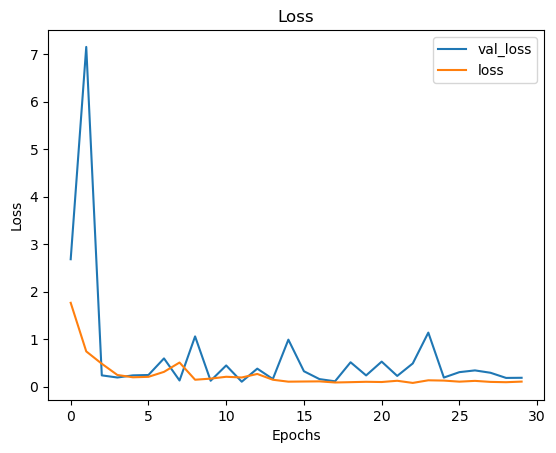

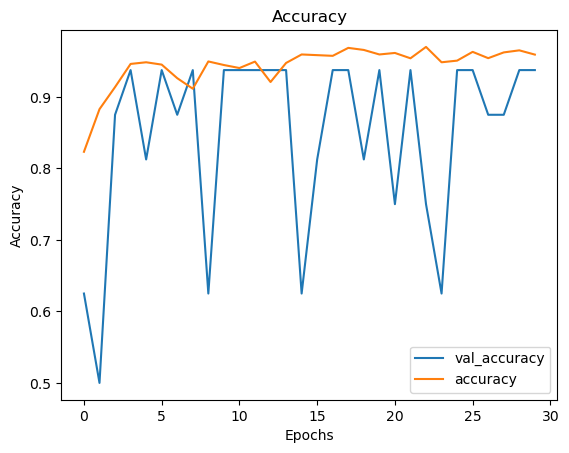

In [33]:
# Viewing results 
visualize_training_results(results_6)

With increasing Epochs from 20 to 30, there was slight improvement training accuracy going from ~93% to ~96%, however test accuracy remained virtually the same at ~81%. Since the model seemed to increase in overfitting with 30 Epochs. Planning to try one additional adjustment regarding Epochs with testing model by reducing to 15 Epochs. 

## Model 7

In [34]:
# Model 7 Epochs will be adjusted to 15


model_7 = Sequential()
model_7.add(Dense(64, activation='relu', input_shape=(196608,)))
model_7.add(Dense(32, activation='relu'))
model_7.add(Dense(16, activation='relu'))
model_7.add(Dense(1, activation='sigmoid'))

# Compiling model with following parameters
model_7.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Inspecting model summary

model_7.summary()

# Fitting the model to the training data
results_7 = model_7.fit(train_img, train_y, 
                        epochs=15, 
                        batch_size=32, 
                        validation_data=(val_img, val_y))



Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 64)                12582976  
                                                                 
 dense_23 (Dense)            (None, 32)                2080      
                                                                 
 dense_24 (Dense)            (None, 16)                528       
                                                                 
 dense_25 (Dense)            (None, 1)                 17        
                                                                 
Total params: 12,585,601
Trainable params: 12,585,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
163/163 [==============================] - 45s 265ms/step - loss: 2.3676 - accuracy: 0.8459 - val_loss: 1.0944 - val_accuracy: 0.6875
Epoch 2/15
163/163 [=========

In [35]:
# Training Results 
results7_train = model_7.evaluate(train_img, train_y)

# Test Results 
results7_test = model_7.evaluate(test_img, test_y)

print('Train Results:', results7_train)
print('Test Results:', results7_test)

20/20 [==============================] - 3s 109ms/step - loss: 0.5536 - accuracy: 0.8045
Train Results: [0.22628697752952576, 0.9112346768379211]
Test Results: [0.5536491870880127, 0.8044871687889099]


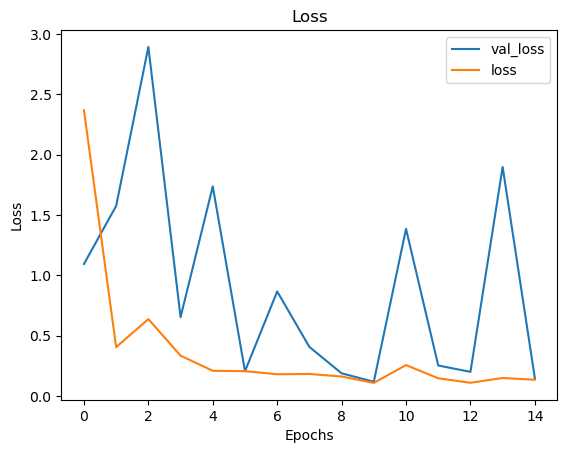

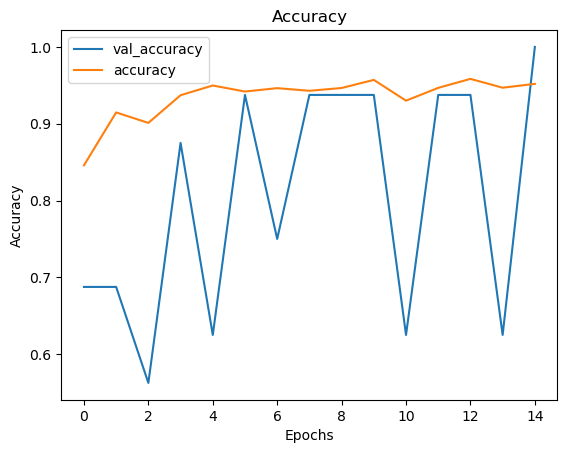

In [37]:
# Viewing results 
visualize_training_results(results_7)

## Model 8

In [54]:
# Model 8 Epochs of 20 
# L1 regularization added

model_8 = Sequential()
model_8.add(Dense(64, activation='relu', input_shape=(196608,)))
model_8.add(Dense(32, activation='relu', kernel_regularizer=l1(0.01)))
model_8.add(Dense(16, activation='relu'))
model_8.add(Dense(1, activation='sigmoid'))

# Compiling model with following parameters
model_8.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Inspecting model summary

model_8.summary()

# Fitting the model to the training data
results_8 = model_8.fit(train_img, train_y, 
                        epochs=20, 
                        batch_size=32, 
                        validation_data=(val_img, val_y))



Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 64)                12582976  
                                                                 
 dense_49 (Dense)            (None, 32)                2080      
                                                                 
 dense_50 (Dense)            (None, 16)                528       
                                                                 
 dense_51 (Dense)            (None, 1)                 17        
                                                                 
Total params: 12,585,601
Trainable params: 12,585,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
163/163 [==============================] - 74s 435ms/step - loss: 2.6271 - accuracy: 0.8455 - val_loss: 1.2184 - val_accuracy: 0.8750
Epoch 2/20
163/163 [========

In [55]:
# Training Results 
results8_train = model_8.evaluate(train_img, train_y)

# Test Results 
results8_test = model_8.evaluate(test_img, test_y)

print('Train Results:', results8_train)
print('Test Results:', results8_test)

20/20 [==============================] - 4s 176ms/step - loss: 1.3803 - accuracy: 0.7212
Train Results: [0.25414934754371643, 0.9675996899604797]
Test Results: [1.3803304433822632, 0.7211538553237915]


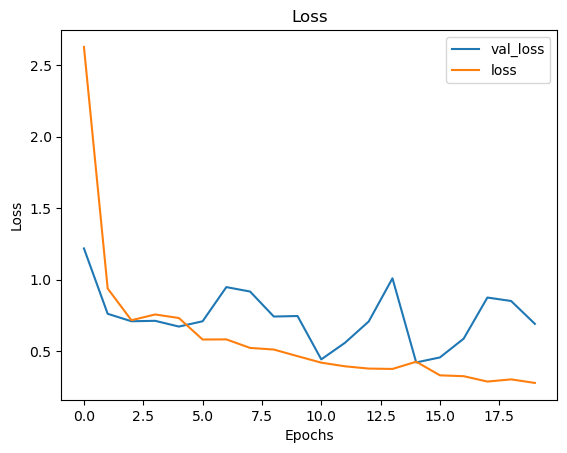

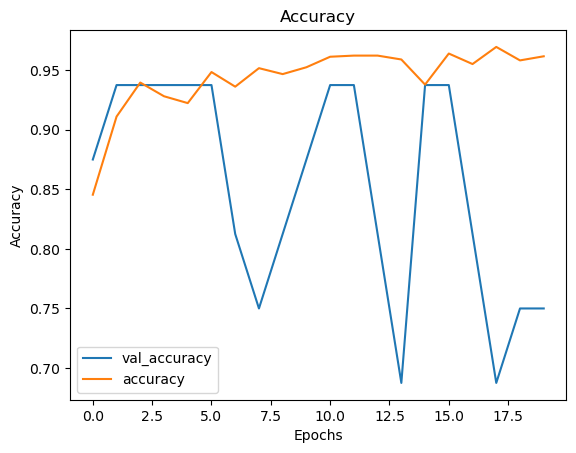

In [56]:
# Viewing results 
visualize_training_results(results_8)

## Model 9

In [57]:
# Model 9 Epochs of 20, added one extra layer
# added l2 regularization to multiple layers


model_9 = Sequential()
model_9.add(Dense(64, activation='relu', input_shape=(196608,)))
model_8.add(Dense(32, activation='relu', kernel_regularizer=l2(0.05)))
model_9.add(Dense(16, activation='relu', kernel_regularizer=l2(0.05)))
model_9.add(Dense(8, activation='relu', kernel_regularizer=l2(0.05)))
model_9.add(Dense(1, activation='sigmoid'))

# Compiling model with following parameters
model_9.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Inspecting model summary

model_9.summary()

# Fitting the model to the training data
results_9 = model_9.fit(train_img, train_y, 
                        epochs=20, 
                        batch_size=32, 
                        validation_data=(val_img, val_y))



Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_52 (Dense)            (None, 64)                12582976  
                                                                 
 dense_54 (Dense)            (None, 16)                1040      
                                                                 
 dense_55 (Dense)            (None, 8)                 136       
                                                                 
 dense_56 (Dense)            (None, 1)                 9         
                                                                 
Total params: 12,584,161
Trainable params: 12,584,161
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
163/163 [==============================] - 76s 437ms/step - loss: 1.9623 - accuracy: 0.6848 - val_loss: 1.5152 - val_accuracy: 0.5000
Epoch 2/20
163/163 [========

KeyboardInterrupt: 

In [59]:
# Model 9 Epochs of 20, added one extra layer
# took away regularization
# adjusted neurons in layers and added 1 additional layer


model_9 = Sequential()
model_9.add(Dense(128, activation='relu', input_shape=(196608,)))
model_8.add(Dense(64, activation='relu'))
model_9.add(Dense(32, activation='relu'))
model_9.add(Dense(16, activation='relu'))
model_9.add(Dense(8, activation='relu'))
model_9.add(Dense(1, activation='sigmoid'))

# Compiling model with following parameters
model_9.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Inspecting model summary

model_9.summary()

# Fitting the model to the training data
results_9 = model_9.fit(train_img, train_y, 
                        epochs=20, 
                        batch_size=32, 
                        validation_data=(val_img, val_y))



Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_62 (Dense)            (None, 128)               25165952  
                                                                 
 dense_64 (Dense)            (None, 32)                4128      
                                                                 
 dense_65 (Dense)            (None, 16)                528       
                                                                 
 dense_66 (Dense)            (None, 8)                 136       
                                                                 
 dense_67 (Dense)            (None, 1)                 9         
                                                                 
Total params: 25,170,753
Trainable params: 25,170,753
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
163/163 [=====================

In [60]:
# Training Results 
results9_train = model_9.evaluate(train_img, train_y)

# Test Results 
results9_test = model_9.evaluate(test_img, test_y)

print('Train Results:', results9_train)
print('Test Results:', results9_test)

20/20 [==============================] - 5s 121ms/step - loss: 1.4485 - accuracy: 0.7019
Train Results: [0.10469038784503937, 0.9534125924110413]
Test Results: [1.4485394954681396, 0.7019230723381042]


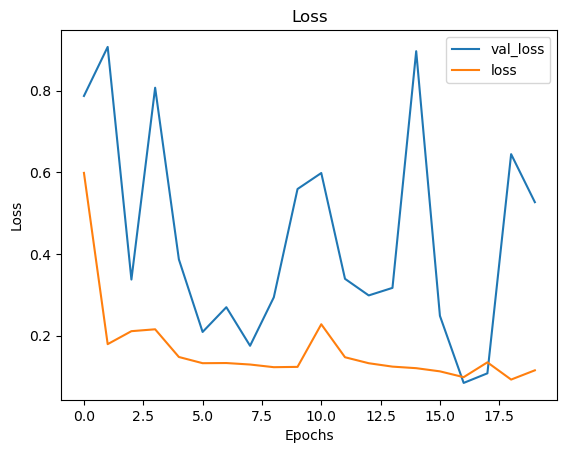

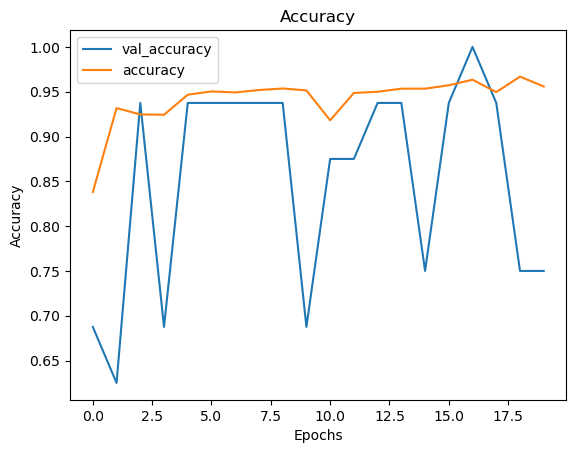

In [61]:
# Viewing results 
visualize_training_results(results_9)

## Building the CNN Model

In [72]:
# Baseline CNN

cnn_model = Sequential()
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))

cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(64, activation='relu'))
cnn_model.add(layers.Dense(2, activation='softmax'))


# Reviewing model summary
cnn_model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 flatten_2 (Flatten)         (None, 230400)          

In [73]:
# Compiling model
cnn_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fitting the model

cnn_model.fit(train_images, train_labels, epochs=10, batch_size=32)

Epoch 1/10
163/163 [==============================] - 442s 3s/step - loss: 0.3070 - accuracy: 0.8815
Epoch 2/10
163/163 [==============================] - 561s 3s/step - loss: 0.1055 - accuracy: 0.9647
Epoch 3/10
163/163 [==============================] - 636s 4s/step - loss: 0.0682 - accuracy: 0.9764
Epoch 4/10
163/163 [==============================] - 652s 4s/step - loss: 0.0505 - accuracy: 0.9803
Epoch 5/10
163/163 [==============================] - 495s 3s/step - loss: 0.0337 - accuracy: 0.9877
Epoch 6/10
163/163 [==============================] - 477s 3s/step - loss: 0.0234 - accuracy: 0.9918
Epoch 7/10
163/163 [==============================] - 503s 3s/step - loss: 0.0132 - accuracy: 0.9954
Epoch 8/10
163/163 [==============================] - 471s 3s/step - loss: 0.0106 - accuracy: 0.9962
Epoch 9/10
163/163 [==============================] - 502s 3s/step - loss: 0.0090 - accuracy: 0.9971
Epoch 10/10
163/163 [==============================] - 486s 3s/step - loss: 0.0276 - accura

In [74]:
# Evaluating the model
cnn_result_train = cnn_model.evaluate(train_images, train_labels)
cnn_result_test = cnn_model.evaluate(test_images, test_labels)


print('Train Results:', cnn_result_train)
print('Test Results:', cnn_result_test)

20/20 [==============================] - 26s 1s/step - loss: 1.7180 - accuracy: 0.7644
Train Results: [0.05409827083349228, 0.9831288456916809]
Test Results: [1.7180132865905762, 0.7644230723381042]


## CNN Model 2

In [75]:
# CNN Model 2
# Changed loss function to binary crossentropy
# Adjusted final layer to have 1 neuron while switching the activation function to sigmoid

cnn_model2 = Sequential()
cnn_model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
cnn_model2.add(layers.MaxPooling2D((2, 2)))
cnn_model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model2.add(layers.MaxPooling2D((2, 2)))
cnn_model2.add(layers.Conv2D(64, (3, 3), activation='relu'))

cnn_model2.add(layers.Flatten())
cnn_model2.add(layers.Dense(64, activation='relu'))
cnn_model2.add(layers.Dense(1, activation='softmax'))


# Reviewing model summary
cnn_model2.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 60, 60, 64)        36928     
                                                                 
 flatten_3 (Flatten)         (None, 230400)          

In [77]:
# Compiling model
cnn_model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Fitting the model

cnn_model2.fit(train_images, train_labels, epochs=10, batch_size=32)

Epoch 1/10
163/163 [==============================] - 392s 2s/step - loss: 0.3540 - accuracy: 0.7429
Epoch 2/10
163/163 [==============================] - 343s 2s/step - loss: 0.1086 - accuracy: 0.7429
Epoch 3/10
163/163 [==============================] - 344s 2s/step - loss: 0.0875 - accuracy: 0.7429
Epoch 4/10
163/163 [==============================] - 343s 2s/step - loss: 0.0576 - accuracy: 0.7429
Epoch 5/10
163/163 [==============================] - 356s 2s/step - loss: 0.0414 - accuracy: 0.7429
Epoch 6/10
163/163 [==============================] - 335s 2s/step - loss: 0.0403 - accuracy: 0.7429
Epoch 7/10
163/163 [==============================] - 370s 2s/step - loss: 0.0209 - accuracy: 0.7429
Epoch 8/10
163/163 [==============================] - 359s 2s/step - loss: 0.0177 - accuracy: 0.7429
Epoch 9/10
163/163 [==============================] - 334s 2s/step - loss: 0.0125 - accuracy: 0.7429
Epoch 10/10
163/163 [==============================] - 335s 2s/step - loss: 0.0103 - accura

In [78]:
# Evaluating the model
cnn_result_train2 = cnn_model2.evaluate(train_images, train_labels)
cnn_result_test2 = cnn_model2.evaluate(test_images, test_labels)


print('Train Results:', cnn_result_train2)
print('Test Results:', cnn_result_test2)

20/20 [==============================] - 15s 674ms/step - loss: 1.5583 - accuracy: 0.6250
Train Results: [0.02156638912856579, 0.7429064512252808]
Test Results: [1.5583068132400513, 0.625]


# Baseline model

model_1 = Sequential()
model_1.add(Dense(12, activation='relu', input_shape=(196608,)))
model_1.add(Dense(8, activation='relu'))
model_1.add(Dense(1, activation='sigmoid'))

# Compiling model with following parameters
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Inspecting model summary

model_1.summary()

# Fitting the model to the training data
results_2 = model_2.fit(train_img, train_y, 
                        epochs=10, 
                        batch_size=32, 
                        validation_data=(val_img, val_y))

# Training Results 
results3_train = model_3.evaluate(train_img, train_y)

# Test Results 

results3_test = model_3.evaluate(test_img, test_y)

print('Train Results:', results3_train)
print('Test Results:', results3_test)

# Viewing results 
visualize_training_results(results_3)

## Model Adjustments 

In [ ]:
# Baseline model

model_1 = Sequential()
model_1.add(Dense(12, activation='relu', input_shape=(196608,)))
model_1.add(Dense(8, activation='relu'))
model_1.add(Dense(1, activation='sigmoid'))

# Compiling model with following parameters
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Inspecting model summary

model_1.summary()

# Fitting the model to the training data
results_1 = model_1.fit(train_img, train_y, 
                        epochs=10, 
                        batch_size=32, 
                        validation_data=(val_img, val_y))

# Training Results 
results_train = model_1.evaluate(train_img, train_y)

# Test Results 
results_test = model_1.evaluate(test_img, test_y)

print('Train Results:', results_train)
print('Test Results:', results_test)

In [79]:
# Baseline model

model_nn= Sequential()
model_nn.add(Dense(12, activation='sigmoid', input_shape=(196608,)))
model_nn.add(Dense(8, activation='sigmoid'))
model_nn.add(Dense(1, activation='sigmoid'))

# Compiling model with following parameters
model_nn.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])

# Inspecting model summary

model_nn.summary()

# Fitting the model to the training data
results_nn = model_nn.fit(train_img, train_y, 
                        epochs=10, 
                        batch_size=32, 
                        validation_data=(val_img, val_y))

# Training Results 
results_train_nn = model_nn.evaluate(train_img, train_y)

# Test Results 
results_test_nn = model_nn.evaluate(test_img, test_y)

print('Train Results:', results_train_nn)
print('Test Results:', results_test_nn)

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_76 (Dense)            (None, 12)                2359308   
                                                                 
 dense_77 (Dense)            (None, 8)                 104       
                                                                 
 dense_78 (Dense)            (None, 1)                 9         
                                                                 
Total params: 2,359,421
Trainable params: 2,359,421
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
163/163 [==============================] - 24s 132ms/step - loss: 0.5569 - accuracy: 0.7429 - val_loss: 0.7666 - val_accuracy: 0.5000
Epoch 2/10
163/163 [==============================] - 12s 73ms/step - loss: 0.4917 - accuracy: 0.7429 - val_loss: 0.6861 - val_accuracy: 0.5000
Epoch 3/10
163/163

In [80]:
# model 2 with additional layers and change of activation function to relu

model_nn = Sequential()
model_nn.add(Dense(64, activation='relu', input_shape=(196608,)))
model_nn.add(Dense(32, activation='relu'))
model_nn.add(Dense(16, activation='relu'))
model_nn.add(Dense(1, activation='sigmoid'))

# Compiling model with following parameters
model_nn.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])

# Inspecting model summary

model_nn.summary()

# Fitting the model to the training data
results_nn = model_nn.fit(train_img, train_y, 
                        epochs=10, 
                        batch_size=32, 
                        validation_data=(val_img, val_y))

# Training Results 
results_train_nn = model_nn.evaluate(train_img, train_y)

# Test Results 
results_test_nn = model_nn.evaluate(test_img, test_y)

print('Train Results:', results_train_nn)
print('Test Results:', results_test_nn)

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_79 (Dense)            (None, 64)                12582976  
                                                                 
 dense_80 (Dense)            (None, 32)                2080      
                                                                 
 dense_81 (Dense)            (None, 16)                528       
                                                                 
 dense_82 (Dense)            (None, 1)                 17        
                                                                 
Total params: 12,585,601
Trainable params: 12,585,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
163/163 [==============================] - 25s 141ms/step - loss: 0.5357 - accuracy: 0.7573 - val_loss: 1.2520 - val_accuracy: 0.5000
Epoch 2/10
163/163 [========

In [82]:
# model 3 with additional layers and change of activation function to relu
# and increase of epochs to 20

model_nn = Sequential()
model_nn.add(Dense(64, activation='relu', input_shape=(196608,)))
model_nn.add(Dense(32, activation='relu'))
model_nn.add(Dense(16, activation='relu'))
model_nn.add(Dense(1, activation='sigmoid'))

# Compiling model with following parameters
model_nn.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])

# Inspecting model summary

model_nn.summary()

# Fitting the model to the training data
results_nn = model_nn.fit(train_img, train_y, 
                        epochs=20, 
                        batch_size=32, 
                        validation_data=(val_img, val_y))

# Training Results 
results_train_nn = model_nn.evaluate(train_img, train_y)

# Test Results 
results_test_nn = model_nn.evaluate(test_img, test_y)

print('Train Results:', results_train_nn)
print('Test Results:', results_test_nn)

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_83 (Dense)            (None, 64)                12582976  
                                                                 
 dense_84 (Dense)            (None, 32)                2080      
                                                                 
 dense_85 (Dense)            (None, 16)                528       
                                                                 
 dense_86 (Dense)            (None, 1)                 17        
                                                                 
Total params: 12,585,601
Trainable params: 12,585,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
163/163 [==============================] - 25s 142ms/step - loss: 0.5331 - accuracy: 0.7372 - val_loss: 0.7522 - val_accuracy: 0.5000
Epoch 2/20
163/163 [========

In [83]:
# model 4 with additional layers and change of activation function to relu
# and decrease of epochs back to 10
# changed optimizer to 'adam'

model_nn = Sequential()
model_nn.add(Dense(64, activation='relu', input_shape=(196608,)))
model_nn.add(Dense(32, activation='relu'))
model_nn.add(Dense(16, activation='relu'))
model_nn.add(Dense(1, activation='sigmoid'))

# Compiling model with following parameters
model_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Inspecting model summary

model_nn.summary()

# Fitting the model to the training data
results_nn = model_nn.fit(train_img, train_y, 
                        epochs=10, 
                        batch_size=32, 
                        validation_data=(val_img, val_y))

# Training Results 
results_train_nn = model_nn.evaluate(train_img, train_y)

# Test Results 
results_test_nn = model_nn.evaluate(test_img, test_y)

print('Train Results:', results_train_nn)
print('Test Results:', results_test_nn)

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_87 (Dense)            (None, 64)                12582976  
                                                                 
 dense_88 (Dense)            (None, 32)                2080      
                                                                 
 dense_89 (Dense)            (None, 16)                528       
                                                                 
 dense_90 (Dense)            (None, 1)                 17        
                                                                 
Total params: 12,585,601
Trainable params: 12,585,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
163/163 [==============================] - 42s 246ms/step - loss: 2.5161 - accuracy: 0.8336 - val_loss: 0.3435 - val_accuracy: 0.8750
Epoch 2/10
163/163 [========

In [84]:
# model 4 with additional layers and change of activation function to relu
# and decrease of epochs back to 10
# changed optimizer back to 'SGD'

model_nn = Sequential()
model_nn.add(Dense(64, activation='relu', input_shape=(196608,)))
model_nn.add(Dense(32, activation='relu'))
model_nn.add(Dense(16, activation='relu'))
model_nn.add(Dense(1, activation='sigmoid'))

# Compiling model with following parameters
model_nn.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])

# Inspecting model summary

model_nn.summary()

# Fitting the model to the training data
results_nn = model_nn.fit(train_img, train_y, 
                        epochs=10, 
                        batch_size=32, 
                        validation_data=(val_img, val_y))

# Training Results 
results_train_nn = model_nn.evaluate(train_img, train_y)

# Test Results 
results_test_nn = model_nn.evaluate(test_img, test_y)

print('Train Results:', results_train_nn)
print('Test Results:', results_test_nn)

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_91 (Dense)            (None, 64)                12582976  
                                                                 
 dense_92 (Dense)            (None, 32)                2080      
                                                                 
 dense_93 (Dense)            (None, 16)                528       
                                                                 
 dense_94 (Dense)            (None, 1)                 17        
                                                                 
Total params: 12,585,601
Trainable params: 12,585,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
163/163 [==============================] - 22s 125ms/step - loss: 0.7115 - accuracy: 0.7345 - val_loss: 0.7016 - val_accuracy: 0.5000
Epoch 2/10
163/163 [========

In [85]:
# model 5 with additional layers and change of activation function to relu
# and decrease of epochs back to 10
# changed optimizer to 'rmsprop'

model_nn = Sequential()
model_nn.add(Dense(64, activation='relu', input_shape=(196608,)))
model_nn.add(Dense(32, activation='relu'))
model_nn.add(Dense(16, activation='relu'))
model_nn.add(Dense(1, activation='sigmoid'))

# Compiling model with following parameters
model_nn.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Inspecting model summary

model_nn.summary()

# Fitting the model to the training data
results_nn = model_nn.fit(train_img, train_y, 
                        epochs=10, 
                        batch_size=32, 
                        validation_data=(val_img, val_y))

# Training Results 
results_train_nn = model_nn.evaluate(train_img, train_y)

# Test Results 
results_test_nn = model_nn.evaluate(test_img, test_y)

print('Train Results:', results_train_nn)
print('Test Results:', results_test_nn)

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_95 (Dense)            (None, 64)                12582976  
                                                                 
 dense_96 (Dense)            (None, 32)                2080      
                                                                 
 dense_97 (Dense)            (None, 16)                528       
                                                                 
 dense_98 (Dense)            (None, 1)                 17        
                                                                 
Total params: 12,585,601
Trainable params: 12,585,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
163/163 [==============================] - 33s 191ms/step - loss: 6.7974 - accuracy: 0.7030 - val_loss: 8.7003 - val_accuracy: 0.5000
Epoch 2/10
163/163 [========

In [86]:
# model 6 with additional layers and change of activation function to relu
# changed optimizer to 'rmsprop'
# adjusting epochs to 20

model_nn = Sequential()
model_nn.add(Dense(64, activation='relu', input_shape=(196608,)))
model_nn.add(Dense(32, activation='relu'))
model_nn.add(Dense(16, activation='relu'))
model_nn.add(Dense(1, activation='sigmoid'))

# Compiling model with following parameters
model_nn.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Inspecting model summary

model_nn.summary()

# Fitting the model to the training data
results_nn = model_nn.fit(train_img, train_y, 
                        epochs=20, 
                        batch_size=32, 
                        validation_data=(val_img, val_y))

# Training Results 
results_train_nn = model_nn.evaluate(train_img, train_y)

# Test Results 
results_test_nn = model_nn.evaluate(test_img, test_y)

print('Train Results:', results_train_nn)
print('Test Results:', results_test_nn)

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_99 (Dense)            (None, 64)                12582976  
                                                                 
 dense_100 (Dense)           (None, 32)                2080      
                                                                 
 dense_101 (Dense)           (None, 16)                528       
                                                                 
 dense_102 (Dense)           (None, 1)                 17        
                                                                 
Total params: 12,585,601
Trainable params: 12,585,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
163/163 [==============================] - 39s 227ms/step - loss: 3.4808 - accuracy: 0.7036 - val_loss: 0.4998 - val_accuracy: 0.7500
Epoch 2/20
163/163 [========

With adjusting and increasing epochs, there was a decrease in performance in both the training set and the test set. 

In [95]:
# Flatten the NumPy array to a 1D array
flat_train_y = train_y.flatten()

# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(flat_train_y), y=flat_train_y)

# Create a dictionary to map class indices to their respective weights
class_weights_dict = dict(enumerate(class_weights))

In [97]:
# model 7 with additional layers and change of activation function to relu
# and epochs back at 10
# changed optimizer to 'rmsprop'
# adjusting for class imbalance 

# Calculate class weights and pass into model
# Flatten the NumPy array to a 1D array
flat_train_y = train_y.flatten()

# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(flat_train_y), y=flat_train_y)

# Create a dictionary to map class indices to their respective weights
class_weights_dict = dict(enumerate(class_weights))

model_nn = Sequential()
model_nn.add(Dense(64, activation='relu', input_shape=(196608,)))
model_nn.add(Dense(32, activation='relu'))
model_nn.add(Dense(16, activation='relu'))
model_nn.add(Dense(1, activation='sigmoid'))

# Compiling model with following parameters
#model_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Compiling model with following parameters
model_nn.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'], class_weights=class_weights_dict)


# Inspecting model summary

model_nn.summary()

# Fitting the model to the training data
results_nn = model_nn.fit(train_img, train_y, 
                        epochs=10, 
                        batch_size=32, 
                        validation_data=(val_img, val_y))

# Training Results 
results_train_nn = model_nn.evaluate(train_img, train_y)

# Test Results 
results_test_nn = model_nn.evaluate(test_img, test_y)

print('Train Results:', results_train_nn)
print('Test Results:', results_test_nn)

TypeError: Invalid keyword argument(s) in `compile()`: ({'class_weights'},). Valid keyword arguments include "cloning", "experimental_run_tf_function", "distribute", "target_tensors", or "sample_weight_mode".

In [99]:
# model 7 with additional layers and change of activation function to relu
# and epochs back at 10
# changed optimizer to 'rmsprop'
# adjusting for class imbalance 

# Calculate class weights and pass into model
model_nn = Sequential()
model_nn.add(Dense(64, activation='relu', input_shape=(196608,)))
model_nn.add(Dense(12, activation='sigmoid'))
model_nn.add(Dense(8, activation='sigmoid'))
model_nn.add(Dense(1, activation='sigmoid'))

# Compile the model without specifying class weights
model_nn.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Flatten the NumPy array to a 1D array
flat_train_y = train_y.flatten()

# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(flat_train_y), y=flat_train_y)

# Create a dictionary to map class indices to their respective weights
class_weights_dict = dict(enumerate(class_weights))

# Fitting the model with class weights
results_nn = model_nn.fit(train_img, train_y, 
                          epochs=10, 
                          batch_size=32, 
                          validation_data=(val_img, val_y),
                          class_weight=class_weights_dict)

# Training Results 
results_train_nn = model_nn.evaluate(train_img, train_y)

# Test Results 
results_test_nn = model_nn.evaluate(test_img, test_y)

print('Train Results:', results_train_nn)
print('Test Results:', results_test_nn)

Epoch 1/10
163/163 [==============================] - 35s 196ms/step - loss: 0.6960 - accuracy: 0.6321 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/10
163/163 [==============================] - 30s 182ms/step - loss: 0.6937 - accuracy: 0.5458 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/10
163/163 [==============================] - 27s 166ms/step - loss: 0.6937 - accuracy: 0.5681 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/10
163/163 [==============================] - 35s 214ms/step - loss: 0.6938 - accuracy: 0.4987 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/10
163/163 [==============================] - 29s 178ms/step - loss: 0.6936 - accuracy: 0.5036 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/10
163/163 [==============================] - 28s 170ms/step - loss: 0.6935 - accuracy: 0.4753 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/10
163/163 [==============================] - 27s 164ms/step - loss: 0.6937 - accuracy: 0.5523 - val_loss: 0.6932 - val_ac

In this model, class imbalance was adjusted for however, this lead to a decrease in both train and test performance.

In [99]:
# model 8 with additional layers and change of activation function to relu
# and epochs back at 10
# changed optimizer to 'rmsprop'



model_nn = Sequential()
model_nn.add(Dense(64, activation='relu', input_shape=(196608,)))
model_nn.add(Dense(12, activation='sigmoid'))
model_nn.add(Dense(8, activation='sigmoid'))
model_nn.add(Dense(1, activation='sigmoid'))

# Compile the model without specifying class weights
model_nn.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])


# Fitting the model with class weights
results_nn = model_nn.fit(train_img, train_y, 
                          epochs=10, 
                          batch_size=32, 
                          validation_data=(val_img, val_y))

# Training Results 
results_train_nn = model_nn.evaluate(train_img, train_y)

# Test Results 
results_test_nn = model_nn.evaluate(test_img, test_y)

print('Train Results:', results_train_nn)
print('Test Results:', results_test_nn)

Epoch 1/10
163/163 [==============================] - 35s 196ms/step - loss: 0.6960 - accuracy: 0.6321 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/10
163/163 [==============================] - 30s 182ms/step - loss: 0.6937 - accuracy: 0.5458 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/10
163/163 [==============================] - 27s 166ms/step - loss: 0.6937 - accuracy: 0.5681 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/10
163/163 [==============================] - 35s 214ms/step - loss: 0.6938 - accuracy: 0.4987 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/10
163/163 [==============================] - 29s 178ms/step - loss: 0.6936 - accuracy: 0.5036 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/10
163/163 [==============================] - 28s 170ms/step - loss: 0.6935 - accuracy: 0.4753 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/10
163/163 [==============================] - 27s 164ms/step - loss: 0.6937 - accuracy: 0.5523 - val_loss: 0.6932 - val_ac

In [100]:
# model 9 with additional layers and change of activation function to relu
# and decrease of epochs back to 10
# changed optimizer to 'rmsprop'
# added another layer 

model_nn = Sequential()
model_nn.add(Dense(128, activation='relu', input_shape=(196608,)))
model_nn.add(Dense(64, activation='relu'))
model_nn.add(Dense(32, activation='relu'))
model_nn.add(Dense(16, activation='relu'))
model_nn.add(Dense(1, activation='sigmoid'))

# Compiling model with following parameters
model_nn.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Inspecting model summary

model_nn.summary()

# Fitting the model to the training data
results_nn = model_nn.fit(train_img, train_y, 
                        epochs=10, 
                        batch_size=32, 
                        validation_data=(val_img, val_y))

# Training Results 
results_train_nn = model_nn.evaluate(train_img, train_y)

# Test Results 
results_test_nn = model_nn.evaluate(test_img, test_y)

print('Train Results:', results_train_nn)
print('Test Results:', results_test_nn)

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_119 (Dense)           (None, 128)               25165952  
                                                                 
 dense_120 (Dense)           (None, 64)                8256      
                                                                 
 dense_121 (Dense)           (None, 32)                2080      
                                                                 
 dense_122 (Dense)           (None, 16)                528       
                                                                 
 dense_123 (Dense)           (None, 1)                 17        
                                                                 
Total params: 25,176,833
Trainable params: 25,176,833
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
163/163 [=====================

Adding the additional layer led to a decrease in test performance and an increase in training performing resulting in a higher degree of overfitting with this model. 

In [103]:
# model 10 with additional layers and change of activation function to relu
# and decrease of epochs back to 10
# changed optimizer to 'rmsprop'
# adding batch normalization to the model and removing the layer that was added previously

model_nn = Sequential()
model_nn.add(Dense(64, input_shape=(196608,)))
model_nn.add(BatchNormalization())
model_nn.add(Activation('relu'))
model_nn.add(Dense(32))
model_nn.add(BatchNormalization())
model_nn.add(Activation('relu'))
model_nn.add(Dense(16))
model_nn.add(BatchNormalization())
model_nn.add(Activation('relu'))
model_nn.add(Dense(1, activation='sigmoid'))


# Compiling model with following parameters
model_nn.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Inspecting model summary

model_nn.summary()

# Fitting the model to the training data
results_nn = model_nn.fit(train_img, train_y, 
                        epochs=10, 
                        batch_size=32, 
                        validation_data=(val_img, val_y))

# Training Results 
results_train_nn = model_nn.evaluate(train_img, train_y)

# Test Results 
results_test_nn = model_nn.evaluate(test_img, test_y)

print('Train Results:', results_train_nn)
print('Test Results:', results_test_nn)

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_125 (Dense)           (None, 64)                12582976  
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 64)                0         
                                                                 
 dense_126 (Dense)           (None, 32)                2080      
                                                                 
 batch_normalization_2 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 32)              

Batch normalization was introduced into this model which reduced overfitting greatly and resulted in a test performance of 81% and a training performance of 85%. While the training performance was lower than the previous model, test performance has been one of the highest and this model has the least amount of overfitting.

In [107]:
# model 11 with additional layers and change of activation function to relu
# increasing epochs to 20
# changed optimizer to 'rmsprop'
# adding batch normalization to the model and removing the layer that was added previously

model_nn = Sequential()
model_nn.add(Dense(64, input_shape=(196608,)))
model_nn.add(BatchNormalization())
model_nn.add(Activation('relu'))
model_nn.add(Dense(32))
model_nn.add(BatchNormalization())
model_nn.add(Activation('relu'))
model_nn.add(Dense(16))
model_nn.add(BatchNormalization())
model_nn.add(Activation('relu'))
model_nn.add(Dense(1, activation='sigmoid'))


# Compiling model with following parameters
model_nn.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Inspecting model summary

model_nn.summary()

# Fitting the model to the training data
results_nn = model_nn.fit(train_img, train_y, 
                        epochs=20, 
                        batch_size=32, 
                        validation_data=(val_img, val_y))

# Training Results 
results_train_nn = model_nn.evaluate(train_img, train_y)

# Test Results 
results_test_nn = model_nn.evaluate(test_img, test_y)

print('Train Results:', results_train_nn)
print('Test Results:', results_test_nn)

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_133 (Dense)           (None, 64)                12582976  
                                                                 
 batch_normalization_4 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 64)                0         
                                                                 
 dense_134 (Dense)           (None, 32)                2080      
                                                                 
 batch_normalization_5 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 32)              

Increasing epochs from 10 to 20 resulted in an increase in train accuracy and a decrease in test accuracy. Increasing the epochs led to the model showing signs of overfitting. 

In [108]:
# model 12 with additional layers and change of activation function to relu
# and decrease of epochs back to 10
# changed optimizer to 'rmsprop'
# adjusted learning rate of optimizer
# added batch normalization 



model_nn = Sequential()
model_nn.add(Dense(64, input_shape=(196608,)))
model_nn.add(BatchNormalization())
model_nn.add(Activation('relu'))
model_nn.add(Dense(32))
model_nn.add(BatchNormalization())
model_nn.add(Activation('relu'))
model_nn.add(Dense(16))
model_nn.add(BatchNormalization())
model_nn.add(Activation('relu'))
model_nn.add(Dense(1, activation='sigmoid'))


# Compiling model with following parameters
optimizer = RMSprop(learning_rate=0.001)  # Adjust the learning rate as needed
model_nn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Inspecting model summary

model_nn.summary()

# Fitting the model to the training data
results_nn = model_nn.fit(train_img, train_y, 
                        epochs=10, 
                        batch_size=32, 
                        validation_data=(val_img, val_y))

# Training Results 
results_train_nn = model_nn.evaluate(train_img, train_y)

# Test Results 
results_test_nn = model_nn.evaluate(test_img, test_y)

print('Train Results:', results_train_nn)
print('Test Results:', results_test_nn)

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_137 (Dense)           (None, 64)                12582976  
                                                                 
 batch_normalization_7 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 64)                0         
                                                                 
 dense_138 (Dense)           (None, 32)                2080      
                                                                 
 batch_normalization_8 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 32)              

In [109]:
# model 13 with additional layers and change of activation function to relu
# and decrease of epochs back to 10
# changed optimizer to 'rmsprop'
# adjusted learning rate of optimizer
# added batch normalization 



model_nn = Sequential()
model_nn.add(Dense(64, input_shape=(196608,)))
model_nn.add(BatchNormalization())
model_nn.add(Activation('relu'))
model_nn.add(Dense(32))
model_nn.add(BatchNormalization())
model_nn.add(Activation('relu'))
model_nn.add(Dense(16))
model_nn.add(BatchNormalization())
model_nn.add(Activation('relu'))
model_nn.add(Dense(8))
model_nn.add(BatchNormalization())
model_nn.add(Activation('relu'))
model_nn.add(Dense(1, activation='sigmoid'))


# Compiling model with following parameters
optimizer = RMSprop(learning_rate=0.001)  # Adjust the learning rate as needed
model_nn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Inspecting model summary

model_nn.summary()

# Fitting the model to the training data
results_nn = model_nn.fit(train_img, train_y, 
                        epochs=10, 
                        batch_size=32, 
                        validation_data=(val_img, val_y))

# Training Results 
results_train_nn = model_nn.evaluate(train_img, train_y)

# Test Results 
results_test_nn = model_nn.evaluate(test_img, test_y)

print('Train Results:', results_train_nn)
print('Test Results:', results_test_nn)

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_141 (Dense)           (None, 64)                12582976  
                                                                 
 batch_normalization_10 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 activation_9 (Activation)   (None, 64)                0         
                                                                 
 dense_142 (Dense)           (None, 32)                2080      
                                                                 
 batch_normalization_11 (Bat  (None, 32)               128       
 chNormalization)                                                
                                                                 
 activation_10 (Activation)  (None, 32)              